* notebook created by nov05 on 2025-01-22

In [1]:
from awsglue.context import GlueContext
from pyspark.context import SparkContext

# Initialize GlueContext and SparkContext
sc = SparkContext.getOrCreate()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
# Define the S3 path where the Parquet files are stored
s3_path = "s3://database-aft-vbi-pds/table_metadata_consolidated/"
# Use GlueContext to read the Parquet files into a DynamicFrame
dynamic_frame = glueContext.create_dynamic_frame.from_options(
    connection_type="s3",
    connection_options={"paths": [s3_path]},
    format="parquet"
)
# Convert the DynamicFrame to a DataFrame (if needed)
df = dynamic_frame.toDF()
# Show the contents of the DataFrame
df.show(5)

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/home/glue_user/spark/jars/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/glue_user/spark/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/glue_user/aws-glue-libs/jars/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/glue_user/aws-glue-libs/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Reload4jLoggerFactory]
log4j:WARN No appenders could be found for logger (org.apache.hadoop.metrics2.lib.MutableMetricsFactory).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
/home/glue_us

+--------------------+-----------------+
|      bin_fcsku_data|expected_quantity|
+--------------------+-----------------+
|{B00KUFFIQQ -> {B...|                4|
|{B01DDR0BX2 -> {B...|                4|
|{B00LFSM004 -> {B...|                4|
|{B00I0444P0 -> {B...|                3|
|{B0156J3PUQ -> {B...|                3|
+--------------------+-----------------+
only showing top 5 rows



In [8]:
print(type(df['expected_quantity']))
df_expected_quantity = df.select("expected_quantity").toPandas()
print(type(df_expected_quantity))
expected_quantity = df_expected_quantity['expected_quantity'].tolist()
print(type(expected_quantity))

<class 'pyspark.sql.column.Column'>


<class 'pandas.core.frame.DataFrame'>
<class 'list'>


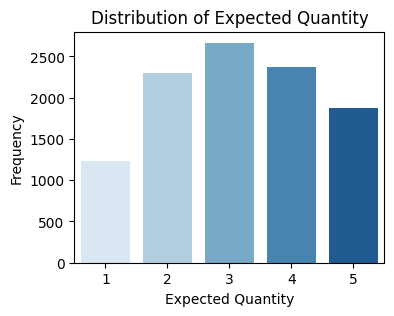

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3))
unique_values = sorted(df_expected_quantity['expected_quantity'].unique())
colors = sns.color_palette("Blues", len(unique_values))
# Plot the distribution of expected_quantity using seaborn
sns.countplot(x=expected_quantity, palette=colors)
plt.title("Distribution of Expected Quantity")
plt.xlabel("Expected Quantity")
plt.ylabel("Frequency")
plt.show()

In [24]:
from pyspark.sql.functions import explode
# Explode the bin_fcsku_data map
df_exploded = df.select("expected_quantity", explode("bin_fcsku_data").alias("key", "fcsku_data"))
# Select the required fields from the fcsku_data struct
df_items = df_exploded.select(
    "fcsku_data.asin", 
    "fcsku_data.name", 
    df_exploded["fcsku_data.normalizedname"].alias("normalized_name"),
    "fcsku_data.quantity",
    df_exploded["fcsku_data.height.value"].alias("height_value"), 
    df_exploded["fcsku_data.height.unit"].alias("height_unit"), 
    df_exploded["fcsku_data.length.value"].alias("length_value"),
    df_exploded["fcsku_data.length.unit"].alias("length_unit"), 
    df_exploded["fcsku_data.width.value"].alias("width_value"),
    df_exploded["fcsku_data.width.unit"].alias("width_unit"), 
    df_exploded["fcsku_data.weight.value"].alias("weight_value"),
    df_exploded["fcsku_data.weight.unit"].alias("weight_unit")
)
# Show the final result
df_items.show(15, truncate=False)

+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+--------------------+-----------+---------------------+-----------+---------------------+----------+--------------------+-----------+
|asin      |name                                                                                                                                                                                                   |normalized_name                                                                                                                                                                                        |quantity|height_value        |hei

In [ ]:
## there are 16,187 unique ASINs in the dataset
df_exploded.select("fcsku_data.asin").distinct().count()

16187

In [35]:
## there are 0 null ASINs in the dataset
df_exploded.filter(df_exploded["fcsku_data.asin"].isNull()).count()

0

In [ ]:
## there are null values in the height_unit column
df_exploded.select("fcsku_data.height.unit").distinct().show()

+----+
|unit|
+----+
|null|
|  IN|
+----+



In [ ]:
from pyspark.sql import functions as F

# Group by 'asin' and aggregate the 'quantity' column
df_quantity = df_exploded.groupBy("fcsku_data.asin").agg(
    F.first("fcsku_data.name").alias("name"),               # Keep the first occurrence of 'name'
    F.first("fcsku_data.normalizedname").alias("normalized_name"),  # Rename 'normalizedname' to 'normalized_name'
    F.sum("fcsku_data.quantity").alias("total_quantity"),    # Sum the 'quantity' for each asin
    F.first("fcsku_data.height").alias("height"),            # Keep first occurrence of 'height'
    F.first("fcsku_data.length").alias("length"),            # Keep first occurrence of 'length'
    F.first("fcsku_data.width").alias("width"),              # Keep first occurrence of 'width'
    F.first("fcsku_data.weight").alias("weight")             # Keep first occurrence of 'weight'
)

# Show the result
aggregated_df.show(truncate=False)
